Using xgboost or a random forest regressor to determine relevant features

In [1]:
# strat_univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

strat_univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT',
              'BCHUSDT', 'LTCUSDT']

In [2]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [59]:
data_freq = '4h'
day_periods = 6

look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
# in_sample_end_datetime = pd.to_datetime('2022-08-05 04:00:00')
in_sample_end_datetime = pd.to_datetime('2023-12-31 20:00:00')

In [60]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for ADAUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XRPUSDT.
Downloaded data for DOTUSDT.
Downloaded data for MATICUSDT.
Downloaded data for BCHUSDT.
Downloaded data for LTCUSDT.


In [61]:
import numpy as np

def get_signals(price_volume_df):
    coin_signals_data = dict()
    #coin_signals = pd.DataFrame(0.0, columns = [], index=price_volume_df.index)

    coin_signals_data["price-1"] = price_volume_df["close"].shift()
    coin_signals_data["price-2"] = price_volume_df["close"].shift(2)
    coin_signals_data["price-3"] = price_volume_df["close"].shift(3)
    coin_signals_data["log price-1"] = np.log(coin_signals_data["price-1"])
    coin_signals_data["log price-2"] = np.log(coin_signals_data["price-2"])
    coin_signals_data["log price-3"] = np.log(coin_signals_data["price-3"])
    coin_signals_data["price-1 - price-2"] = coin_signals_data["price-1"] - coin_signals_data["price-2"]
    coin_signals_data["price-2 - price-3"] = coin_signals_data["price-2"] - coin_signals_data["price-3"]
    coin_signals_data["price-1 - price-3"] = coin_signals_data["price-1"] - coin_signals_data["price-3"]
    coin_signals_data["price change rate 1-2"] = coin_signals_data["price-1"] / coin_signals_data["price-2"] - 1
    coin_signals_data["price change rate 2-3"] = coin_signals_data["price-2"] / coin_signals_data["price-3"] - 1
    coin_signals_data["log price quotient 1-2"] = np.log(coin_signals_data["price-1"] / coin_signals_data["price-2"])
    coin_signals_data["log price quotient 2-3"] = np.log(coin_signals_data["price-2"] / coin_signals_data["price-3"])

    coin_signals_data["volume-1"] = price_volume_df["volume"].shift()
    coin_signals_data["volume-1"].loc[coin_signals_data["volume-1"] == 0] = 0.001
    coin_signals_data["volume-2"] = price_volume_df["volume"].shift(2)
    coin_signals_data["volume-2"].loc[coin_signals_data["volume-2"] == 0] = 0.001
    coin_signals_data["volume-3"] = price_volume_df["volume"].shift(3)
    coin_signals_data["volume-3"].loc[coin_signals_data["volume-3"] == 0] = 0.001
    coin_signals_data["log volume-1"] = np.log(coin_signals_data["volume-1"])
    coin_signals_data["log volume-2"] = np.log(coin_signals_data["volume-2"])
    coin_signals_data["log volume-3"] = np.log(coin_signals_data["volume-3"])
    coin_signals_data["volume-1 - volume-2"] = coin_signals_data["volume-1"] - coin_signals_data["volume-2"]
    coin_signals_data["volume-2 - volume-3"] = coin_signals_data["volume-2"] - coin_signals_data["volume-3"]
    coin_signals_data["volume-1 - volume-3"] = coin_signals_data["volume-1"] - coin_signals_data["volume-3"]
    coin_signals_data["volume change rate 1-2"] = coin_signals_data["volume-1"] / coin_signals_data["volume-2"] - 1
    coin_signals_data["volume change rate 2-3"] = coin_signals_data["volume-2"] / coin_signals_data["volume-3"] - 1
    coin_signals_data["log volume quotient 1-2"] = np.log(coin_signals_data["volume-1"] / coin_signals_data["volume-2"])
    coin_signals_data["log volume quotient 2-3"] = np.log(coin_signals_data["volume-2"] / coin_signals_data["volume-3"])
    coin_signals_data["num trades-1"] = price_volume_df["num_trades"].shift()

    price_columns = [
        "price-1", "price-2", "price-3", "log price-1", "log price-2", "log price-3", "price-1 - price-2",
        "price-2 - price-3", "price-1 - price-3", "price change rate 1-2", "price change rate 2-3",
        "log price quotient 1-2", "log price quotient 2-3"]

    volume_columns = [
        "volume-1", "volume-2", "volume-3", "log volume-1", "log volume-2", "log volume-3",
        "volume-1 - volume-2", "volume-2 - volume-3", "volume-1 - volume-3", "volume change rate 1-2",
        "volume change rate 2-3", "log volume quotient 1-2", "log volume quotient 2-3", "num trades-1"
    ]

    for p_col in price_columns:
        for v_col in volume_columns:
            coin_signals_data[p_col + " x " + v_col] = coin_signals_data[p_col] * coin_signals_data[v_col]
    
    return pd.DataFrame(coin_signals_data, index=price_volume_df.index)


def get_signals_for_all_coins(px_data):
    coin_to_signals = dict()

    for coin in px_data:
        price_volume_df = px_data[coin][["close", "volume", "num_trades"]].astype(float)
        #price_volume_df = px_data[coin][
        #    ["close", "quote_volume"]].rename({"quote_volume": "volume"}, axis=1).astype(float)
        coin_to_signals[coin] = get_signals(price_volume_df)
    
    return coin_to_signals

In [62]:
px_data['BTCUSDT']['close']

open_time
2020-01-01 00:00:00     7230.71000000
2020-01-01 04:00:00     7205.50000000
2020-01-01 08:00:00     7195.80000000
2020-01-01 12:00:00     7233.02000000
2020-01-01 16:00:00     7223.72000000
                            ...      
2025-03-11 20:00:00    82745.07000000
2025-03-12 00:00:00    82193.36000000
2025-03-12 04:00:00    82375.38000000
2025-03-12 08:00:00    82922.99000000
2025-03-12 12:00:00    83022.98000000
Name: close, Length: 11380, dtype: object

In [63]:
m = len(px_data['BTCUSDT'].index)
px_data['BTCUSDT'].index[int(m * 0.5)]


Timestamp('2022-08-07 04:00:00')

In [64]:
from sklearn.ensemble import RandomForestRegressor

coin_to_signals = get_signals_for_all_coins(px_data)
coin_to_rfr_model = dict()

for coin, signals in coin_to_signals.items():
    rfr_model = RandomForestRegressor(random_state=836, max_depth=5)
    
    in_sample_signals = signals.iloc[3:].loc[:in_sample_end_datetime]
    in_sample_close_price = px_data[coin]['close'].iloc[3:].loc[:in_sample_end_datetime]
    
    rfr_model.fit(in_sample_signals, in_sample_close_price)
    coin_to_rfr_model[coin] = rfr_model
    print(f"Model fitted for {coin}.")

Model fitted for BTCUSDT.
Model fitted for ETHUSDT.
Model fitted for ADAUSDT.
Model fitted for BNBUSDT.
Model fitted for XRPUSDT.
Model fitted for DOTUSDT.
Model fitted for MATICUSDT.
Model fitted for BCHUSDT.
Model fitted for LTCUSDT.


In [65]:
coin_to_rfr_model['BTCUSDT']

RandomForestRegressor(max_depth=5, random_state=836)

<Axes: xlabel='open_time'>

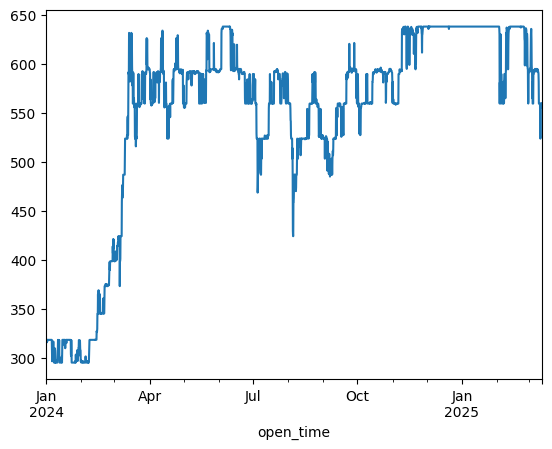

In [66]:
from datetime import timedelta

sample_coin = 'BNBUSDT'

out_sample_start_datetime = in_sample_end_datetime + timedelta(hours=4)
coin_signals_out_sample = coin_to_signals[sample_coin].loc[out_sample_start_datetime:]
coin_out_sample_predictions = coin_to_rfr_model[sample_coin].predict(coin_signals_out_sample)
coin_out_sample_predictions = pd.Series(coin_out_sample_predictions, index=coin_signals_out_sample.index)

coin_out_sample_predictions.plot()

<Axes: xlabel='open_time'>

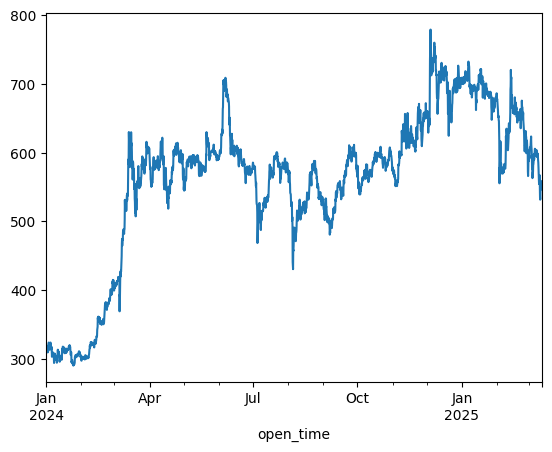

In [67]:
coin_price = px_data[sample_coin].loc[out_sample_start_datetime:]['close'].astype(float)
coin_price.plot()

<Axes: xlabel='open_time'>

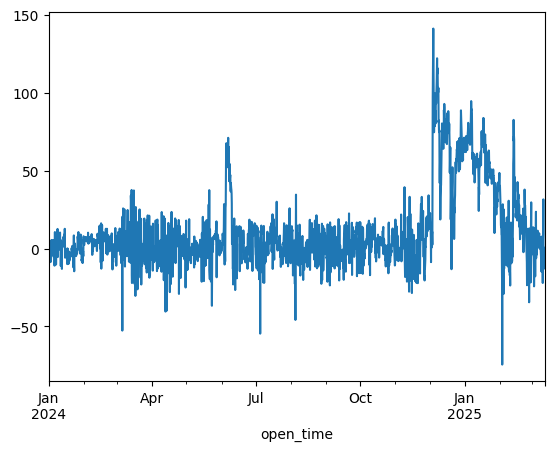

In [68]:
(coin_price - coin_out_sample_predictions).plot()

<Axes: xlabel='open_time'>

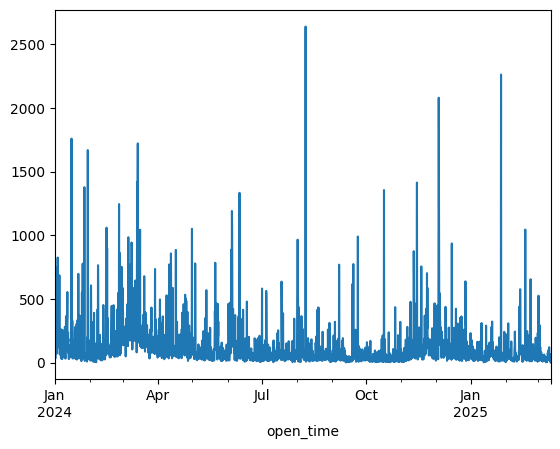

In [69]:
px_data[sample_coin]["volume"].loc[out_sample_start_datetime:].astype(float).plot()

In [70]:
(coin_price - coin_out_sample_predictions).mean()

10.691534922013126

In [71]:
coin_residuals = coin_price - coin_out_sample_predictions
mean = coin_residuals.mean()
std = coin_residuals.std()

(coin_residuals - mean) / std

open_time
2024-01-01 00:00:00   -0.802720
2024-01-01 04:00:00   -0.636982
2024-01-01 08:00:00   -0.793146
2024-01-01 12:00:00   -0.584200
2024-01-01 16:00:00   -0.741818
                         ...   
2025-03-11 20:00:00   -0.691416
2025-03-12 00:00:00   -0.930557
2025-03-12 04:00:00   -0.443998
2025-03-12 08:00:00   -0.456741
2025-03-12 12:00:00   -0.456741
Length: 2620, dtype: float64

In [72]:
coin_to_z_scores = dict()

for coin, model in coin_to_rfr_model.items():
    signals_out_sample = coin_to_signals[coin].loc[out_sample_start_datetime:]
    out_sample_predictions = model.predict(signals_out_sample)
    out_sample_predictions = pd.Series(out_sample_predictions, index=signals_out_sample.index)
    out_sample_price = px_data[coin].loc[out_sample_start_datetime:]['close'].astype(float)
    
    residuals = out_sample_price - out_sample_predictions
    residuals_mean = residuals.mean()
    residuals_std = residuals.std()
    z_scores = (residuals - residuals_mean) / residuals_std
    
    coin_to_z_scores[coin] = z_scores

# eth_out_sample_predictions.plot()

In [73]:
coin_to_z_scores

{'BTCUSDT': open_time
 2024-01-01 00:00:00   -0.682458
 2024-01-01 04:00:00   -0.670250
 2024-01-01 08:00:00   -0.658876
 2024-01-01 12:00:00   -0.658157
 2024-01-01 16:00:00   -0.649180
                          ...   
 2025-03-11 20:00:00    0.589089
 2025-03-12 00:00:00    0.549247
 2025-03-12 04:00:00    0.562392
 2025-03-12 08:00:00    0.601938
 2025-03-12 12:00:00    0.609159
 Length: 2620, dtype: float64,
 'ETHUSDT': open_time
 2024-01-01 00:00:00    0.480167
 2024-01-01 04:00:00    0.613322
 2024-01-01 08:00:00    0.800241
 2024-01-01 12:00:00    0.261226
 2024-01-01 16:00:00    0.682099
                          ...   
 2025-03-11 20:00:00   -1.919781
 2025-03-12 00:00:00    0.367189
 2025-03-12 04:00:00    1.069208
 2025-03-12 08:00:00    1.189404
 2025-03-12 12:00:00    1.189404
 Length: 2620, dtype: float64,
 'ADAUSDT': open_time
 2024-01-01 00:00:00    0.245853
 2024-01-01 04:00:00    0.314928
 2024-01-01 08:00:00    0.203677
 2024-01-01 12:00:00    0.260330
 2024-01-01 16

In [74]:
coin_to_z_scores_df = pd.DataFrame(coin_to_z_scores)
coin_to_z_scores_df

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,BCHUSDT,LTCUSDT
open_time,,,,,,,,,
2024-01-01 00:00:00,-0.682458,0.480167,0.245853,-0.802720,-0.574206,-0.503325,-0.483192,-0.034546,-0.517832
2024-01-01 04:00:00,-0.670250,0.613322,0.314928,-0.636982,-0.558426,0.231750,-0.127213,0.916651,-0.189471
2024-01-01 08:00:00,-0.658876,0.800241,0.203677,-0.793146,-0.563742,0.746451,1.511705,-0.149170,-0.287882
2024-01-01 12:00:00,-0.658157,0.261226,0.260330,-0.584200,-0.564245,0.654978,0.127832,-0.031781,-0.051250
2024-01-01 16:00:00,-0.649180,0.682099,0.678706,-0.741818,-0.559013,1.794667,0.462708,0.559952,-0.018609
...,...,...,...,...,...,...,...,...,...
2025-03-11 20:00:00,0.589089,-1.919781,-1.696015,-0.691416,1.276211,0.175094,NaN,-0.922034,-0.583085
2025-03-12 00:00:00,0.549247,0.367189,-1.834041,-0.930557,1.275647,-0.358670,NaN,0.144844,-0.675944
2025-03-12 04:00:00,0.562392,1.069208,-1.263787,-0.443998,1.307066,-0.244292,NaN,0.932457,0.393649


In [75]:
coin_to_z_scores_df.rank(axis=1)

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,BCHUSDT,LTCUSDT
open_time,,,,,,,,,
2024-01-01 00:00:00,2.0,9.0,8.0,1.0,3.0,5.0,6.0,7.0,4.0
2024-01-01 04:00:00,1.0,8.0,7.0,2.0,3.0,6.0,5.0,9.0,4.0
2024-01-01 08:00:00,2.0,8.0,6.0,1.0,3.0,7.0,9.0,5.0,4.0
2024-01-01 12:00:00,1.0,8.0,7.0,2.0,3.0,9.0,6.0,5.0,4.0
2024-01-01 16:00:00,2.0,8.0,7.0,1.0,3.0,9.0,5.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...
2025-03-11 20:00:00,7.0,1.0,2.0,4.0,8.0,6.0,NaN,3.0,5.0
2025-03-12 00:00:00,7.0,6.0,1.0,2.0,8.0,4.0,NaN,5.0,3.0
2025-03-12 04:00:00,5.0,7.0,1.0,2.0,8.0,3.0,NaN,6.0,4.0


In [76]:
ranked_z_scores = coin_to_z_scores_df.rank(axis=1)
demeaned_ranked_z_scores = ranked_z_scores.subtract(ranked_z_scores.mean(axis=1), axis=0)
demeaned_ranked_z_scores

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,BCHUSDT,LTCUSDT
open_time,,,,,,,,,
2024-01-01 00:00:00,-3.0,4.0,3.0,-4.0,-2.0,0.0,1.0,2.0,-1.0
2024-01-01 04:00:00,-4.0,3.0,2.0,-3.0,-2.0,1.0,0.0,4.0,-1.0
2024-01-01 08:00:00,-3.0,3.0,1.0,-4.0,-2.0,2.0,4.0,0.0,-1.0
2024-01-01 12:00:00,-4.0,3.0,2.0,-3.0,-2.0,4.0,1.0,0.0,-1.0
2024-01-01 16:00:00,-3.0,3.0,2.0,-4.0,-2.0,4.0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...
2025-03-11 20:00:00,2.5,-3.5,-2.5,-0.5,3.5,1.5,NaN,-1.5,0.5
2025-03-12 00:00:00,2.5,1.5,-3.5,-2.5,3.5,-0.5,NaN,0.5,-1.5
2025-03-12 04:00:00,0.5,2.5,-3.5,-2.5,3.5,-1.5,NaN,1.5,-0.5


In [77]:
port_positions = -1 * demeaned_ranked_z_scores.divide(demeaned_ranked_z_scores.abs().sum(axis=1), axis=0)
port_positions

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,BCHUSDT,LTCUSDT
open_time,,,,,,,,,
2024-01-01 00:00:00,0.15000,-0.20000,-0.15000,0.20000,0.10000,-0.00000,-0.05,-0.10000,0.05000
2024-01-01 04:00:00,0.20000,-0.15000,-0.10000,0.15000,0.10000,-0.05000,-0.00,-0.20000,0.05000
2024-01-01 08:00:00,0.15000,-0.15000,-0.05000,0.20000,0.10000,-0.10000,-0.20,-0.00000,0.05000
2024-01-01 12:00:00,0.20000,-0.15000,-0.10000,0.15000,0.10000,-0.20000,-0.05,-0.00000,0.05000
2024-01-01 16:00:00,0.15000,-0.15000,-0.10000,0.20000,0.10000,-0.20000,-0.00,-0.05000,0.05000
...,...,...,...,...,...,...,...,...,...
2025-03-11 20:00:00,-0.15625,0.21875,0.15625,0.03125,-0.21875,-0.09375,NaN,0.09375,-0.03125
2025-03-12 00:00:00,-0.15625,-0.09375,0.21875,0.15625,-0.21875,0.03125,NaN,-0.03125,0.09375
2025-03-12 04:00:00,-0.03125,-0.15625,0.21875,0.15625,-0.21875,0.09375,NaN,-0.09375,0.03125


In [78]:
close_price_df = pd.DataFrame({ticker: px_data[ticker]["close"] for ticker in px_data}).astype(float)
close_price_out_sample_df = close_price_df.loc[out_sample_start_datetime:]
close_price_out_sample_df

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,BCHUSDT,LTCUSDT
open_time,,,,,,,,,
2024-01-01 00:00:00,42320.95,2275.96,0.5951,309.30,0.6128,8.160,0.9677,257.6,72.65
2024-01-01 04:00:00,42490.00,2283.05,0.5985,310.80,0.6151,8.152,0.9665,265.7,73.21
2024-01-01 08:00:00,42666.40,2302.86,0.6019,309.30,0.6206,8.233,0.9872,264.8,73.22
2024-01-01 12:00:00,42749.39,2310.03,0.6042,312.10,0.6213,8.350,0.9937,263.0,73.70
2024-01-01 16:00:00,43328.05,2332.44,0.6155,310.80,0.6252,8.579,1.0032,266.4,73.93
...,...,...,...,...,...,...,...,...,...
2025-03-11 20:00:00,82745.07,1931.48,0.7236,553.01,2.1690,4.040,NaN,339.8,90.49
2025-03-12 00:00:00,82193.36,1874.62,0.7170,547.12,2.1689,3.956,NaN,334.1,88.75
2025-03-12 04:00:00,82375.38,1912.00,0.7353,555.10,2.1920,3.974,NaN,336.5,89.62


In [79]:
close_price_ret = close_price_out_sample_df / close_price_out_sample_df.shift() - 1
close_price_ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,BCHUSDT,LTCUSDT
open_time,,,,,,,,,
2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 04:00:00,0.003994,0.003115,0.005713,0.004850,0.003753,-0.000980,-0.001240,0.031444,0.007708
2024-01-01 08:00:00,0.004152,0.008677,0.005681,-0.004826,0.008942,0.009936,0.021417,-0.003387,0.000137
2024-01-01 12:00:00,0.001945,0.003114,0.003821,0.009053,0.001128,0.014211,0.006584,-0.006798,0.006556
2024-01-01 16:00:00,0.013536,0.009701,0.018702,-0.004165,0.006277,0.027425,0.009560,0.012928,0.003121
...,...,...,...,...,...,...,...,...,...
2025-03-11 20:00:00,-0.003418,-0.012712,-0.011205,-0.005986,-0.020546,-0.009804,NaN,-0.022721,-0.010498
2025-03-12 00:00:00,-0.006668,-0.029439,-0.009121,-0.010651,-0.000046,-0.020792,NaN,-0.016775,-0.019229
2025-03-12 04:00:00,0.002215,0.019940,0.025523,0.014585,0.010651,0.004550,NaN,0.007183,0.009803


In [80]:
weighted_positions = port_positions.shift() * close_price_ret
weighted_positions

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,BCHUSDT,LTCUSDT
open_time,,,,,,,,,
2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 04:00:00,0.000599,-0.000623,-0.000857,0.000970,0.000375,0.000000,0.000062,-0.003144,0.000385
2024-01-01 08:00:00,0.000830,-0.001302,-0.000568,-0.000724,0.000894,-0.000497,-0.000000,0.000677,0.000007
2024-01-01 12:00:00,0.000292,-0.000467,-0.000191,0.001811,0.000113,-0.001421,-0.001317,0.000000,0.000328
2024-01-01 16:00:00,0.002707,-0.001455,-0.001870,-0.000625,0.000628,-0.005485,-0.000478,-0.000000,0.000156
...,...,...,...,...,...,...,...,...,...
2025-03-11 20:00:00,-0.000107,0.002781,-0.002451,-0.000935,0.001926,-0.000919,NaN,0.003550,0.000328
2025-03-12 00:00:00,0.001042,-0.006440,-0.001425,-0.000333,0.000010,0.001949,NaN,-0.001573,0.000601
2025-03-12 04:00:00,-0.000346,-0.001869,0.005583,0.002279,-0.002330,0.000142,NaN,-0.000224,0.000919


In [81]:
gross_return = weighted_positions.sum(axis=1)
gross_return

open_time
2024-01-01 00:00:00    0.000000
2024-01-01 04:00:00   -0.002233
2024-01-01 08:00:00   -0.000682
2024-01-01 12:00:00   -0.000853
2024-01-01 16:00:00   -0.006422
                         ...   
2025-03-11 20:00:00    0.004173
2025-03-12 00:00:00   -0.006168
2025-03-12 04:00:00    0.004154
2025-03-12 08:00:00    0.002002
2025-03-12 12:00:00    0.000201
Freq: 4h, Length: 2620, dtype: float64

<Axes: xlabel='open_time'>

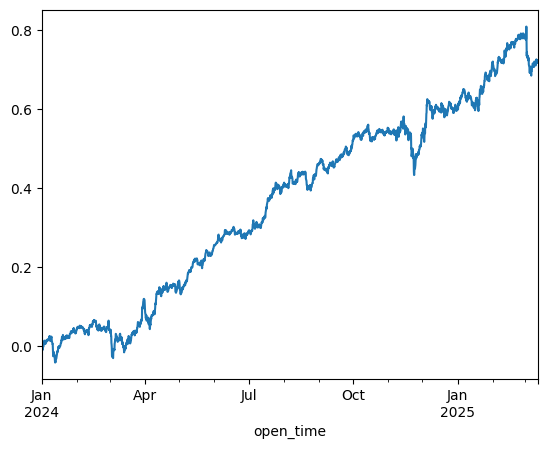

In [82]:
gross_return.cumsum().plot()

In [83]:
to = (port_positions.fillna(0) - port_positions.shift().fillna(0)).abs().sum(1)
to

open_time
2024-01-01 00:00:00    1.000
2024-01-01 04:00:00    0.400
2024-01-01 08:00:00    0.600
2024-01-01 12:00:00    0.400
2024-01-01 16:00:00    0.200
                       ...  
2025-03-11 20:00:00    1.375
2025-03-12 00:00:00    0.875
2025-03-12 04:00:00    0.375
2025-03-12 08:00:00    0.000
2025-03-12 12:00:00    0.000
Freq: 4h, Length: 2620, dtype: float64

In [84]:
tcost_bps = 20 # (commissions + slip)
net_ret = gross_return.subtract(to*tcost_bps*1e-4,fill_value=0)
net_ret

open_time
2024-01-01 00:00:00   -0.002000
2024-01-01 04:00:00   -0.003033
2024-01-01 08:00:00   -0.001882
2024-01-01 12:00:00   -0.001653
2024-01-01 16:00:00   -0.006822
                         ...   
2025-03-11 20:00:00    0.001423
2025-03-12 00:00:00   -0.007918
2025-03-12 04:00:00    0.003404
2025-03-12 08:00:00    0.002002
2025-03-12 12:00:00    0.000201
Freq: 4h, Length: 2620, dtype: float64

Net return - training window up to end of 2023-12-31.

<Axes: xlabel='open_time'>

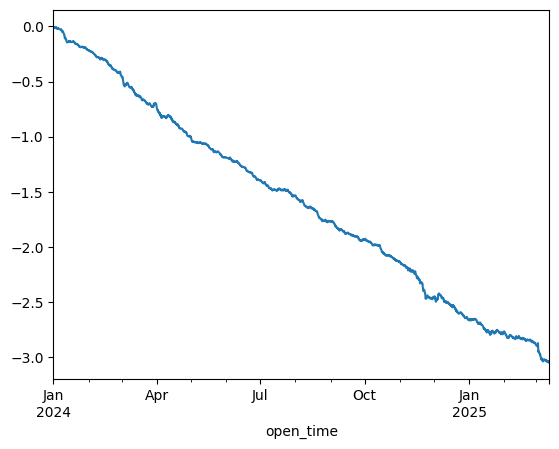

In [85]:
net_ret.cumsum().plot()

In [86]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-12.169069096836077

Net return - added BCHUSDT and LTCUSDT, max_depth = 5, include data from 3 periods ago, include num_trades as signal.

<Axes: xlabel='open_time'>

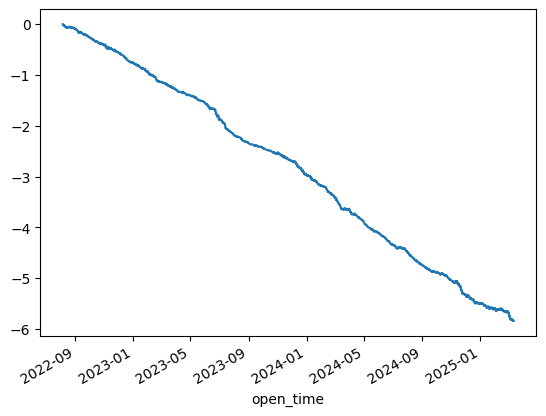

In [28]:
net_ret.cumsum().plot()

In [29]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-12.052258636021655

Net return - small set of coins, max_depth = 5, include data from 3 periods ago, include num_trades as signal.

<Axes: xlabel='open_time'>

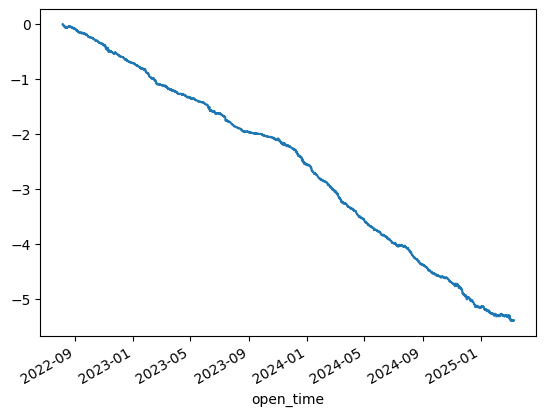

In [40]:
net_ret.cumsum().plot()

In [41]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-11.087692214550495

Net return - small set of coins, max_depth = 5, include data from 3 periods ago

<Axes: xlabel='open_time'>

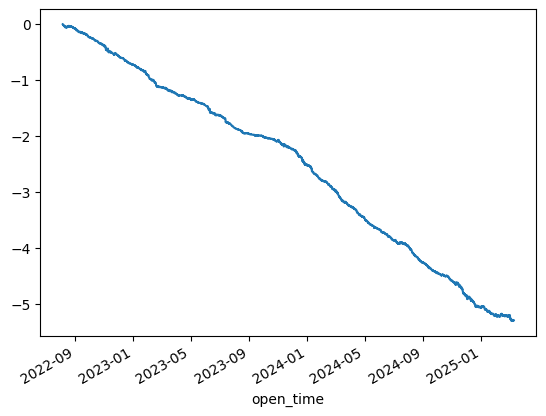

In [109]:
net_ret.cumsum().plot()

In [110]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-10.862042731050774

Net return - small set of coins, max_depth = 5

<Axes: xlabel='open_time'>

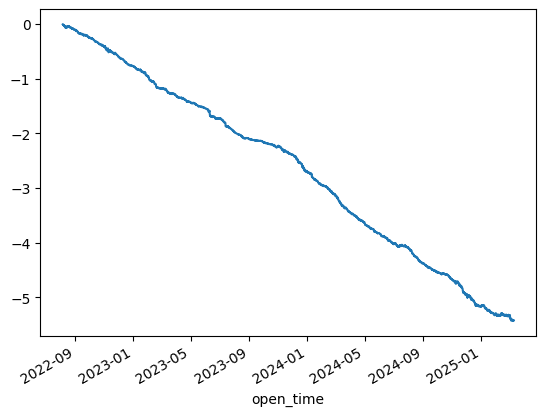

In [72]:
net_ret.cumsum().plot()

In [73]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-11.082618987237904

Net return - small set of coins, max_depth = 10

<Axes: xlabel='open_time'>

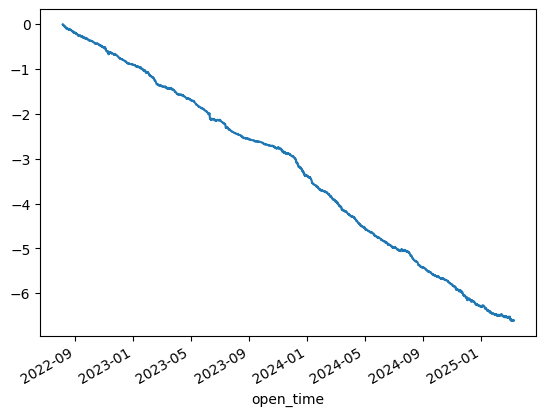

In [50]:
net_ret.cumsum().plot()

In [51]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-13.336161028926432

Net return - small set of coins, no limits on regressor parameters.

<Axes: xlabel='open_time'>

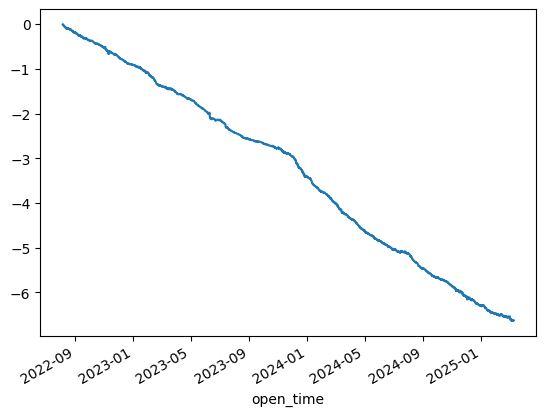

In [28]:
net_ret.cumsum().plot()

In [29]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-13.327196085694583